In [1]:
# Data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# SARIMAX from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For splitting data and error metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv('manipulated_data.csv')

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

data.head()


,date,energy_production,humidity,solar_irradiance,temperature
0,2022-01-01,171965.00,67.903562,671.539150,21.139696
1,2022-01-02,171495.50,64.823080,700.916586,18.734613
2,2022-01-03,183128.00,66.413694,737.124585,22.911354
3,2022-01-04,193922.75,68.619712,784.792551,19.992095
4,2022-01-05,196215.20,59.372813,750.477917,25.732163


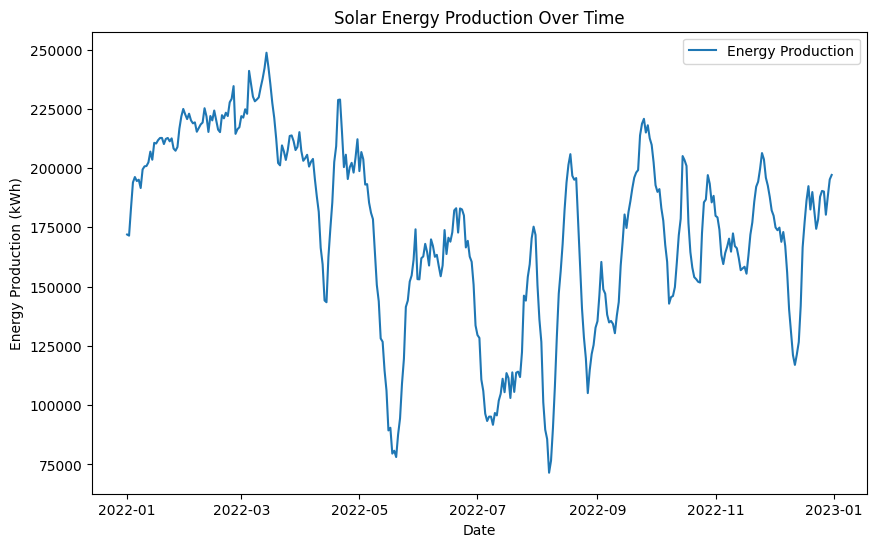

In [3]:
# Plot the solar energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Solar Energy Production Over Time')
plt.legend()
plt.show()

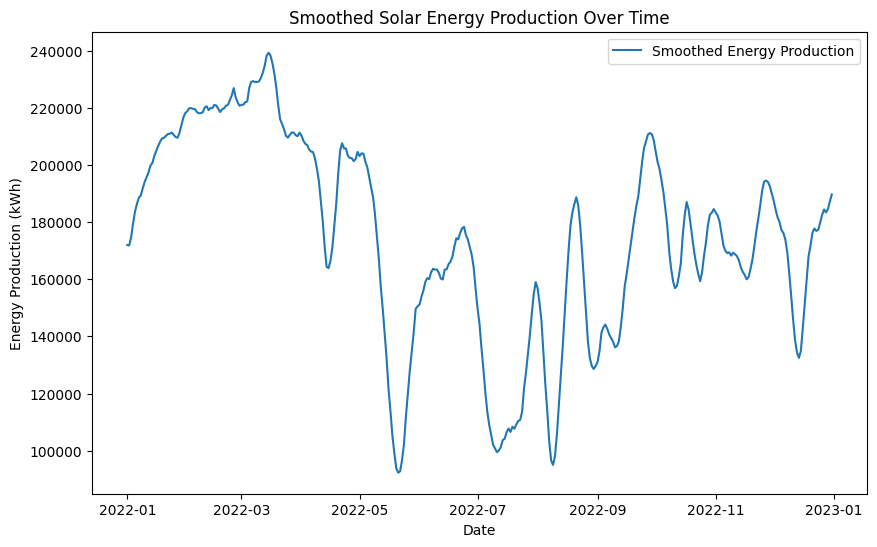

In [4]:
# Apply a moving average with a window size of 7 days
# data['energy_production'] = data['energy_production'].rolling(window=7, min_periods=1).mean()
data['energy_production'] = data['energy_production'].ewm(span=7, adjust=False).mean()

# Plot the smoothed energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Smoothed Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Smoothed Solar Energy Production Over Time')
plt.legend()
plt.show()

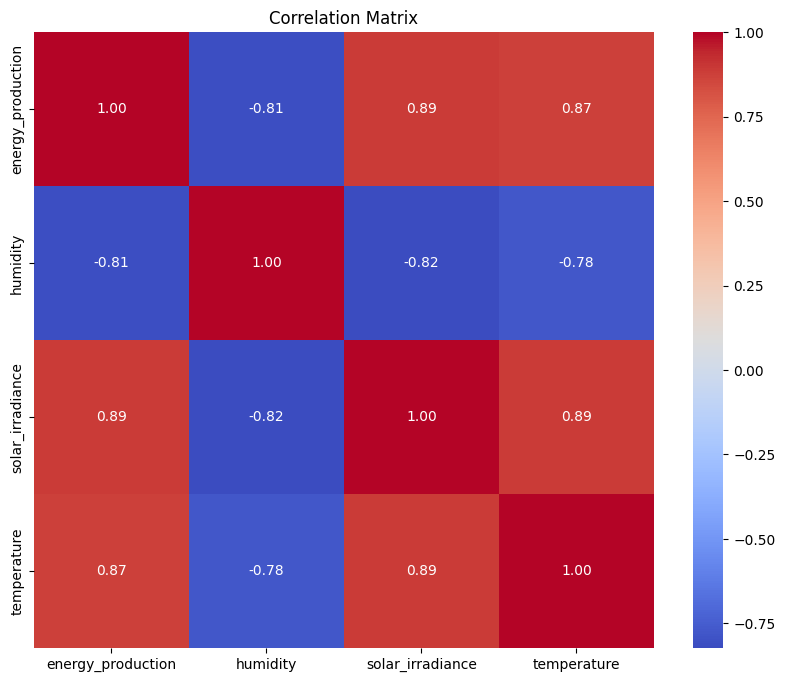

In [5]:
# Filter out non-numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


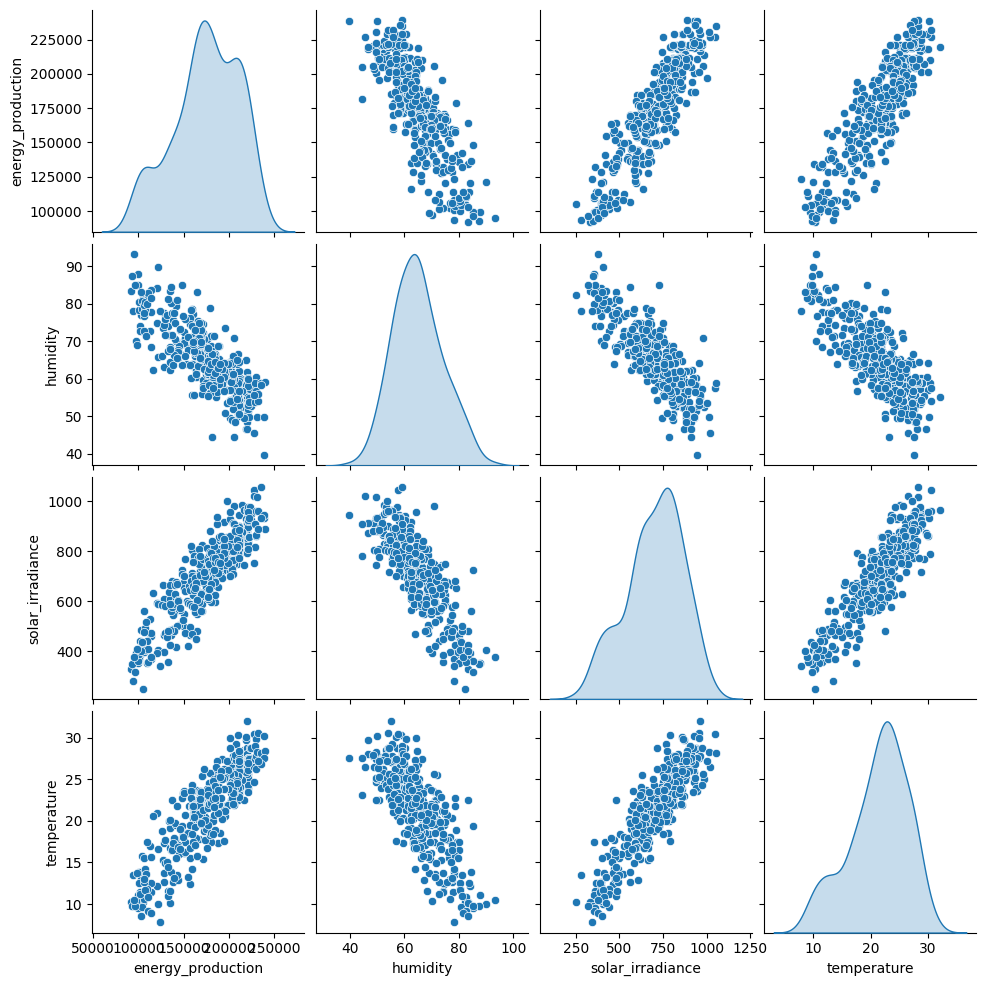

In [6]:
# Plot pairwise relationships between features and target variable
sns.pairplot(data, diag_kind='kde')
plt.show()

In [7]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Split target (y) and exogenous variables (X) for both train and test sets
y_train = train_data['energy_production']
X_train = train_data[['humidity', 'temperature', 'solar_irradiance']]

y_test = test_data['energy_production']
X_test = test_data[['humidity', 'temperature', 'solar_irradiance']]


In [8]:
# Define the SARIMAX model with exogenous variables
model = SARIMAX(y_train,
                exog=X_train,
                order=(1, 1, 1),  # ARIMA parameters: p, d, q
                seasonal_order=(1, 1, 1, 12),  # Seasonal: P, D, Q, m (assuming monthly seasonality)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
sarimax_result = model.fit(disp=False)

# Print model summary
print(sarimax_result.summary())


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                  energy_production   No. Observations:                  292
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2511.492
Date:                            Sun, 20 Oct 2024   AIC                           5038.983
Time:                                    20:11:28   BIC                           5067.621
Sample:                                         0   HQIC                          5050.489
                                            - 292                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
humidity            -6.0949     24.154     -0.252      0.801     -53.437      41.247
temperature      

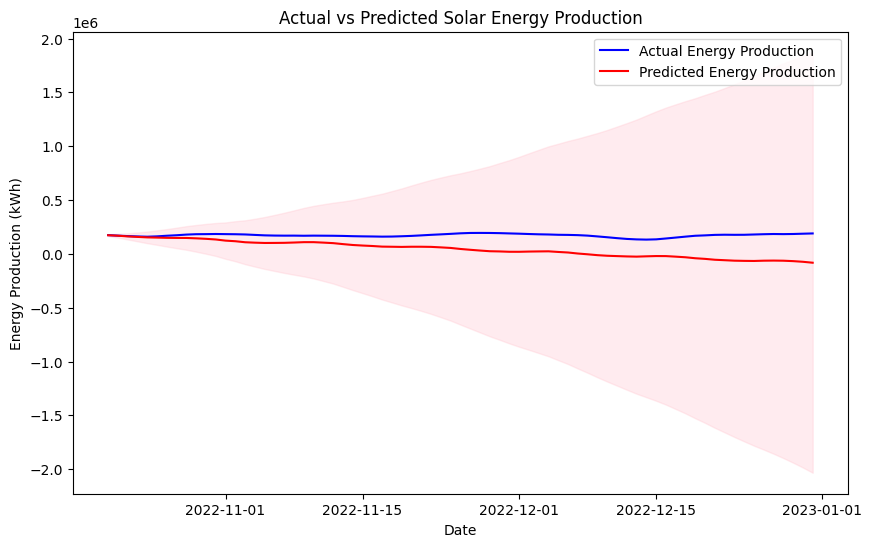

In [9]:
# Forecast the values for the test set (predict using exogenous variables)
forecast = sarimax_result.get_prediction(start=test_data.index[0], end=test_data.index[-1], exog=X_test)

# Get predicted mean values
predicted_values = forecast.predicted_mean
# Plot actual vs predicted energy production
plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual Energy Production', color='blue')
plt.plot(test_data['date'], predicted_values, label='Predicted Energy Production', color='red')
plt.fill_between(test_data['date'],
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Actual vs Predicted Solar Energy Production')
plt.legend()
plt.show()


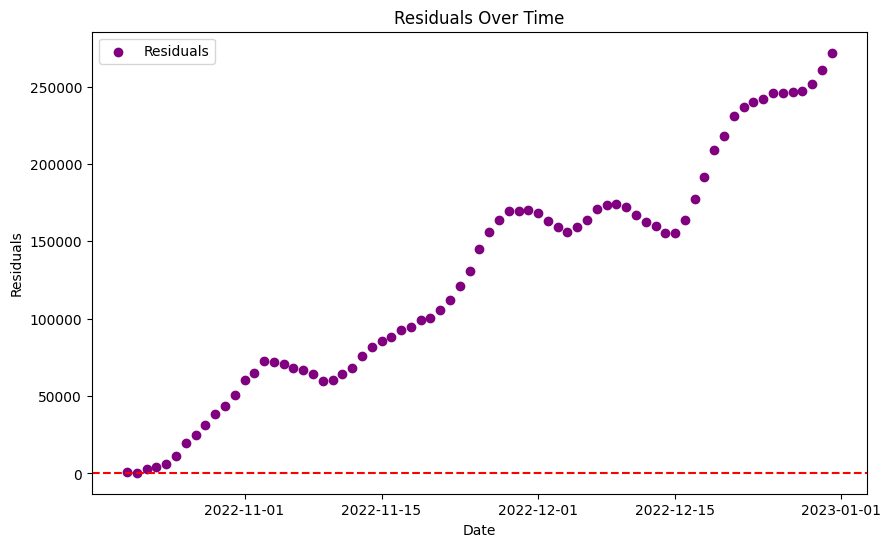

In [10]:
# Scatter plot of residuals over time
plt.figure(figsize=(10,6))
plt.scatter(test_data['date'], y_test - predicted_values, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

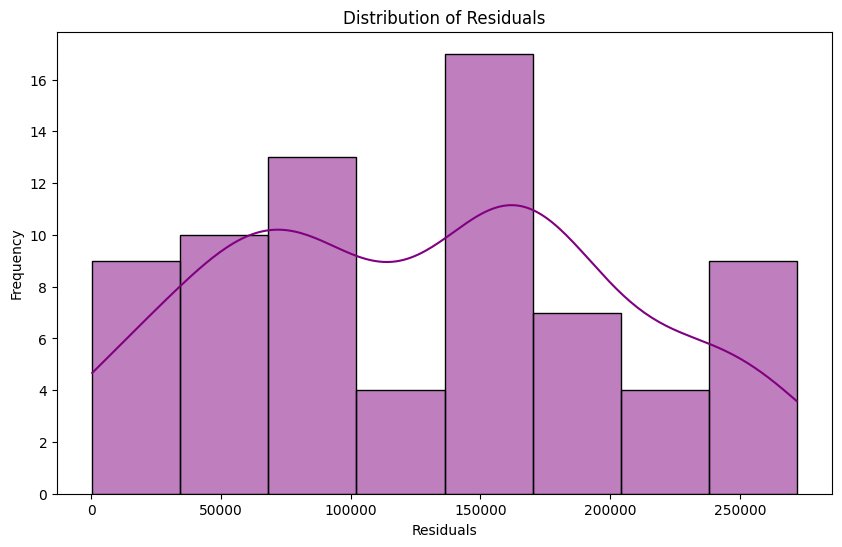

In [11]:
# Plot the distribution of residuals
plt.figure(figsize=(10,6))
sns.histplot(y_test - predicted_values, kde=True, color='purple')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [12]:
# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mean_squared_error(y_test, predicted_values))
print(f'RMSE: {rmse}')

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, predicted_values)
print(f'MAE: {mae}')

# Calculate R² score
r2 = r2_score(y_test, predicted_values)
print(f'R² Score: {r2}')


RMSE: 148249.4706898894
MAE: 127811.4910065884
R² Score: -108.58029666319749


In [13]:
# Calculate accuracy in percentages
accuracy_percentage = abs(r2 * 100)
print(f'Accuracy: {accuracy_percentage:.2f}%')

Accuracy: 10858.03%
